In [1]:
import pandas as pd

#to upload the source
df = pd.read_csv('df_selected_preprocessed.csv')
df.head()


,engine_id,cycle,RUL,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,191,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1,2,190,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1,3,189,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1,4,188,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1,5,187,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [4]:
# size for secuential temporal
window_size = 30
feature_cols = [col for col in df.columns if col not in ['engine_id', 'cycle', 'RUL']]


In [5]:
import numpy as np

def generate_windows(df, window_size, feature_cols):
    X = []
    y = []
    engine_ids = df['engine_id'].unique()

    for engine_id in engine_ids:
        engine_df = df[df['engine_id'] == engine_id].reset_index(drop=True)
        num_cycles = engine_df.shape[0]

        if num_cycles >= window_size:
            for i in range(num_cycles - window_size + 1):
                window = engine_df.loc[i:i+window_size-1, feature_cols].values
                label = engine_df.loc[i+window_size-1, 'RUL']
                X.append(window)
                y.append(label)

    return np.array(X), np.array(y)


In [6]:
X, y = generate_windows(df, window_size, feature_cols)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (17731, 30, 14)
Shape of y: (17731,)


In [7]:
from sklearn.model_selection import train_test_split

# my list of unique IDs
engine_ids = df['engine_id'].unique()

# Train-test split (80% train, 20% test)
train_ids, test_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

# Creating new dataframes
df_train = df[df['engine_id'].isin(train_ids)].reset_index(drop=True)
df_test = df[df['engine_id'].isin(test_ids)].reset_index(drop=True)


In [8]:
X_train, y_train = generate_windows(df_train, window_size, feature_cols)
X_test, y_test = generate_windows(df_test, window_size, feature_cols)


In [9]:
#to confirm that everthing is ok
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14241, 30, 14)
Shape of y_train: (14241,)
Shape of X_test: (3490, 30, 14)
Shape of y_test: (3490,)


In [10]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)


In [11]:
import os

print("Files saved:")
for filename in ['X_train.npy', 'y_train.npy', 'X_test.npy', 'y_test.npy']:
    print(f"{filename}: {'Exists' if os.path.exists(filename) else 'Missing'}")


Files saved:
X_train.npy: Exists
y_train.npy: Exists
X_test.npy: Exists
y_test.npy: Exists


In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")

n_samples_train, time_steps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(n_samples_train, time_steps, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], time_steps, n_features)


np.save("X_train_scaled.npy", X_train_scaled)
np.save("X_test_scaled.npy", X_test_scaled)

print("Scaling complete. Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)


Scaling complete. Shapes:
X_train_scaled: (14241, 30, 14)
X_test_scaled: (3490, 30, 14)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# upload
X_train = np.load("X_train_scaled.npy")
X_test = np.load("X_test_scaled.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# neccesary for critics models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# train the model for linear regressesion
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)

# Predice
y_pred_lr = lr_model.predict(X_test_flat)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)

print("📊 Linear Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


📊 Linear Regression Performance:
RMSE: 29.13
MAE:  23.10


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [15]:
# Load preprocessed and scaled datasets
X_train = np.load("X_train_scaled.npy")
X_test = np.load("X_test_scaled.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")


In [16]:
# dense neural network
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8795.6074 - val_loss: 5247.5488
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3260.3594 - val_loss: 3104.7856
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2184.5176 - val_loss: 2700.1252
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2038.2988 - val_loss: 2802.1514
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1936.9177 - val_loss: 2676.8374
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1867.8149 - val_loss: 2551.5283
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1774.3638 - val_loss: 2731.9321
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1752.9474 - val_loss: 2549.3604
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1691.7444 - val_loss: 2548.0664
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1573.8359 - val_loss: 2601.6169
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1595.1254 - val_lo

In [18]:
# To Predict
y_pred_nn = model.predict(X_test)

# To Calculate metrics
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)

print("📊 Neural Network Performance:")
print(f"RMSE: {rmse_nn:.2f}")
print(f"MAE: {mae_nn:.2f}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📊 Neural Network Performance:
RMSE: 30.90
MAE: 21.09


In [19]:
model.save("model_dense_nn.h5")


In [20]:
import numpy as np

# Load the preprocessed scaled time series data
X_train = np.load("X_train_scaled.npy")
X_test = np.load("X_test_scaled.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (14241, 30, 14)
X_test shape: (3490, 30, 14)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh', input_shape=(30, 14)))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=64,
                               validation_split=0.2, verbose=1)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 10685.5762 - val_loss: 12358.2656
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 8311.8955 - val_loss: 10591.6123
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6893.6309 - val_loss: 9241.1904
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5771.3130 - val_loss: 8195.2002
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5012.8174 - val_loss: 7399.4849
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 4485.4321 - val_loss: 6801.2891
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 4216.0010 - val_loss: 6363.8525
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3944.6360 - val_loss: 6048.5000
Epoch 9/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 3860.6289 - val_loss: 5827.9863
Epoch 10/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3623.7053 - val_loss: 5676.2339
Epoch 11/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3620.4036 - val

In [22]:
# for predictions
y_pred_lstm = model_lstm.predict(X_test)

# performance metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print("📊 LSTM Model Performance:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
📊 LSTM Model Performance:
RMSE: 29.92
MAE: 21.45


Model Evaluation Summary:
               Model   RMSE    MAE
0  Linear Regression  29.13  23.10
1     Neural Network  30.90  21.09
2               LSTM  29.92  21.45


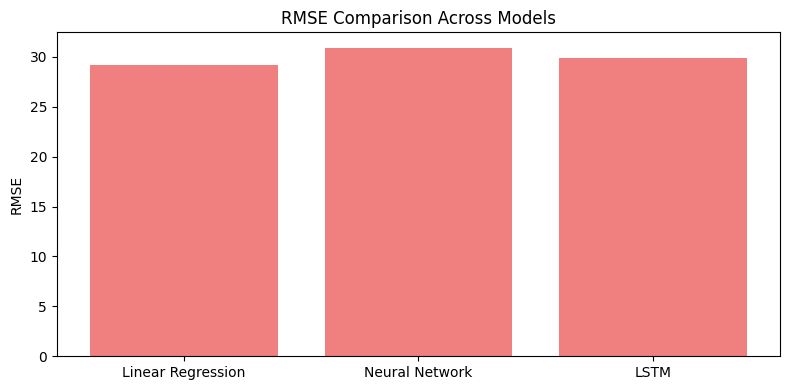

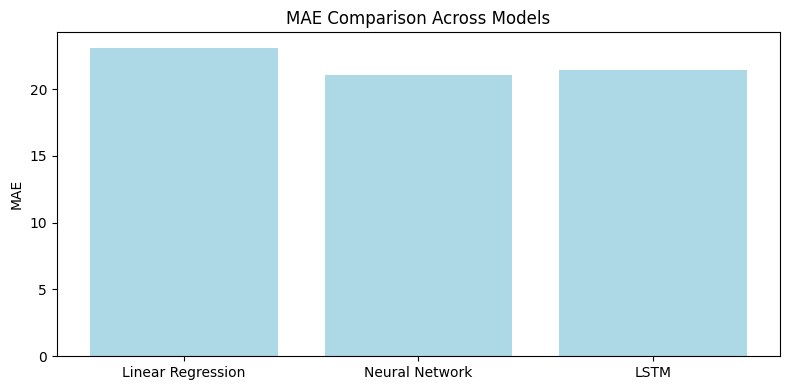

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# model metridcs
results = {
    'Model': ['Linear Regression', 'Neural Network', 'LSTM'],
    'RMSE': [29.13, 30.90, 29.92],
    'MAE': [23.10, 21.09, 21.45]
}

# DataFrame resumen
df_results = pd.DataFrame(results)

# show table
print("Model Evaluation Summary:")
print(df_results)

#  RMSE
plt.figure(figsize=(8, 4))
plt.bar(df_results['Model'], df_results['RMSE'], color='lightcoral')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

#  MAE
plt.figure(figsize=(8, 4))
plt.bar(df_results['Model'], df_results['MAE'], color='lightblue')
plt.title('MAE Comparison Across Models')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()
